In [1177]:
import pandas as pd
import numpy as np
import pickle
import itertools
import re
from typing import List, Tuple, Dict
import operator
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
%matplotlib inline

In [912]:
def np_equal(list1, list2):
    """Return a boolean list of whether 2 elements of the same index are equal in the two given lists"""
    return [x == y for x,y in zip(list1,list2)]

In [913]:
def any_equal(list1, value):
    """Return a boolean list of whether any elements of the given list are equal to the given value"""
    return [x == value for x in list1]

In [914]:
def mult_col_search(df: pd.DataFrame, columns: List[str], 
                    string: str, strict: bool = False) -> Tuple[List[bool], List[np.ndarray]]:
    '''Given a set of dataframe columns, which rows and columns return the substring'''
    if strict:
        col_bool = [df[col]==string for col in columns]
    else:
        col_bool = [df[col].str.contains(string) for col in columns]
    bool_mask = np.dstack(col_bool).squeeze()
    rows = [row.any() for row in bool_mask]
    cols = list(itertools.compress(columns, [c.any() for c in col_bool]))
    return rows, cols

In [915]:
def has_state(loc: str) -> bool:
    '''See if a US state name is in location string'''
    return any((state in loc) & (len(loc.split(','))<3) for state in states)
def has_uni(loc: str) -> bool:
    '''See if any college terms are in location string'''
    return any(re.match(college, loc) 
               for college in [r'(?!.*Park)(?=.*College)^(.*)$', 
                               r'.*University.*', r'.*Tech.*',
                               r'.* State'])
def has_the(loc: str) -> bool:
    '''See if the word "The" is in the beginning of the location string'''
    return re.match(r'^[tT]he .*$', loc)

In [976]:
def name_order2(list1, list2, df_index=0):
    list1 = list(enumerate(list1))
    list2 = list(enumerate(list2))
    l1_len = len(list1)
    if l1_len != len(list2):
        raise ValueError('List lengths must be equal')
    indices = [-1]*l1_len
    for i,x in list1:
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in list2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            list1.append((i,x))
        else:
            indices[next(j for j,n in list2 if x in n)] = i
            l2_ix = next(j for j,n in enumerate(list2) if x in n[1])
            del list2[l2_ix]
    return indices

In [916]:
def name_order(list1, list2, df_index=0):
    l1 = list1.copy()
    l2 = list(enumerate(list2))
    l1_len = len(l1)
    indices = [-1]*l1_len
    if l1_len != len(l2):
        raise ValueError('List lengths must be equal')
    for i,x in enumerate(l1):
        if i > 2*l1_len: raise ValueError('Caught in infinite loop')
        occurrences = sum(x in name[1] for name in l2)
        if occurrences == 0:
            raise ValueError('{} is not in list. Show number = {}'.format(x, df_index))
        elif occurrences > 1:
            l1.append(x)
        else:
            if i >= l1_len: i = indices.index(-1)
            indices[i] = next(j for j,n in l2 if x in n)
            l2_ix = next(j for j,n in enumerate(l2) if x in n[1])
            del l2[l2_ix]
    return indices

In [917]:
#Contestant information dataframe
contestants = pd.read_csv('contestants.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['show_num','date','comments','c1', 'c1_job', 'c1_loc', 'c2', 
                              'c2_job', 'c2_loc', 'c3', 'c3_job', 'c3_loc', 'c4', 'c4_job', 'c4_loc'], 
                     engine='python')

In [918]:
contestants.fillna("", inplace=True)

#Keep to only first names for easier matching
for i in range(1,5):
    #contestants['c'+str(i)] = [re.findall('^([\w"]+)?', name)[0] for name in contestants['c'+str(i)]]
    contestants['c{}_loc'.format(i)] = [loc.strip() for loc in contestants['c{}_loc'.format(i)]]

#Make super jeopardy show numbers unique
superjep_filter = contestants['comments'].str.contains('Super Jeopardy')
#contestants = contestants[~superjep_filter]
contestants.loc[superjep_filter ,'show_num'] = [i + 10000 for i in contestants.loc[superjep_filter ,'show_num']]
#Make super jeopardy show numbers unique
pilot_filter = contestants['comments'].str.contains('Trebek pilot')
contestants.loc[pilot_filter ,'show_num'] = [i + 20000 for i in contestants.loc[pilot_filter ,'show_num']]

In [919]:
#Question dataframe
reader = pd.read_csv('jeopardy_questions.txt', header=None, sep='\|\|', error_bad_lines=True,
                     names = ['season','show_num','question_num','round', 'category', 'difficulty', 
                              'question', 'answer', 'DD', 'c1', 'c1_add', 'c2', 'c2_add', 'c3', 'c3_add', 
                              'c4', 'c4_add'], 
                     engine='python', chunksize = 1000)
episodes = pd.concat([chunk for chunk in reader], ignore_index=True)

In [920]:
for i in range(1,5):
    episodes['c'+str(i)].fillna("", inplace=True)
    episodes['c{}_add'.format(i)].fillna(0, inplace=True)
    episodes['c'+str(i)] = [re.findall('^([\w" ]+)?', name)[0] for name in episodes['c'+str(i)]]
    
#Make super jeopardy show numbers unique
superjep_filter = episodes['season']=='superjeopardy'
#episodes = episodes[~superjep_filter]
episodes.loc[superjep_filter ,'show_num'] = [i + 10000 for i in episodes.loc[superjep_filter ,'show_num']]
#Make Trebek Pilot show numbers unique
pilot_filter = episodes['season']=='trebekpilots'
episodes.loc[pilot_filter ,'show_num'] = [i + 20000 for i in episodes.loc[pilot_filter ,'show_num']]

In [921]:
#filter for seeing if any episodes have contestants with the same first name
name_columns = ['c1', 'c2', 'c3', 'c4']
first_names = [[name.split(' ')[0] for name in 
                episodes[contestant]] for contestant in 
               name_columns]
same_names = [any(names) for names in 
              zip(*[np_equal(*name_couple) for name_couple in 
                    itertools.combinations(first_names, 2)])]

In [922]:
num_names = [[len(name.split(' ')) for name in episodes[contestant]] for contestant in name_columns]
two_name_indices = [i for contestant in num_names for i,x in enumerate(contestant) if x>1]

In [923]:
#question dataframe name corrections
qdf_name_changes = {(61, 'c2'): 'Daniel', (62, 'c2'): 'Daniel', (63, 'c1'): 'Daniel', (191, 'c2'): 'Michael',
                    (308, 'c1'): 'Paul Croshier', (690, 'c2'): 'Denny', (712, 'c3'): 'Chloe', (789, 'c1'): 'Ernest', 
                    (789, 'c2'): 'Christine', (804, 'c2'): 'David Javerbaum', (805, 'c2'): 'David Javerbaum', 
                    (829, 'c1'): 'Arthur', (834, 'c3'): 'Michael', (834, 'c2'): 'Daniel', 
                    (842, 'c1'): 'Dorothy', (1245, 'c3'): 'Steven', (1246, 'c3'): 'Steven', (1286, 'c3'): 'Mary', 
                    (1635, 'c1'): 'Vincent', (2574, 'c1'): 'Charles', (2575, 'c3'): 'Thomas', (2926, 'c1'): 'Rob', 
                    (2929, 'c1'): 'Benjamin',(3023, 'c2'): 'Jimmy', (3124, 'c2'): 'Bob', (3123, 'c2'): 'Bob', 
                    (3125, 'c2'): 'Bob', (3756, 'c3'): 'Sandra', (3757, 'c3'): 'Benjamin', (3757, 'c1'): 'Anastasia',
                    (4520, 'c3'): 'Scott', (4521, 'c1'): 'Scott', (4519, 'c2'): 'Scott', (4522, 'c2'): 'Scott',
                    (4523, 'c2'): 'Scott', (4608, 'c3'): 'Scott', (4647, 'c2'): 'Christina', (5097, 'c3'): 'Ozgun',
                    (5104, 'c2'): 'Brian', (5110, 'c2'): 'Jacob', (5716, 'c1'): 'Francois',
                    (5717, 'c1'): 'Francois', (5718, 'c2'): 'Francois', (5772, 'c2'): 'Debra', (6432, 'c2'): 'Injee',
                    (6179, 'c3'): 'Andrew', (6380, 'c2'): 'Thomas', (6934, 'c1'): 'Che', 
                    (7301, 'c2'): 'Jonathan', (7301, 'c3'): 'S.E.', (7437, 'c2'): 'Rebecca',}

In [924]:
for key in qdf_name_changes:
    episodes.loc[episodes['show_num']==key[0], key[1]] = qdf_name_changes[key]

In [925]:
for i in range(1,5):
    contestants.loc[:,'c{}_add'.format(i)] = 0

In [926]:
episodes = pd.merge(episodes,
                        contestants, 
                        on='show_num', 
                        suffixes=['_y',''])

In [927]:
df2_name_filter = ['c{}_y'.format(i) for i in range(1,5)]
df1_name_filter = ['c{}'.format(i) for i in range(1,5)]
episode_df2_slice = episodes[df2_name_filter].copy()

In [977]:
df2_correct_order = [name_order2(list(ep[df2_name_filter].values), list(ep[df1_name_filter].values), i) 
                     for i,ep in episodes.iterrows()]

In [986]:
add_columns = ['c{}_add'.format(x) for x in range(1,5)]
episodes.loc[:,add_columns] = [[episodes.loc[i,'c{}_add_y'.format(df2_i+1)] for df2_i in order] 
                               for i,order in enumerate(df2_correct_order)]
episodes.drop(['c{}_y'.format(i) for i in range(1,5)], axis=1, inplace=True)
episodes.drop(['c{}_add_y'.format(i) for i in range(1,5)], axis=1, inplace=True)

In [1113]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [1110]:
'''episodes = pd.read_csv('episode_df_saved.csv', sep='¤', engine='python')
episodes.drop('Unnamed: 0', axis=1, inplace=True)'''

In [1157]:
all_episodes = episodes.copy()
episodes = episodes[(episodes['season'] != 'superjeopardy') & (episodes['season'] != 'trebekpilots')]

In [837]:
num_name_matches = [len(set(episodes.iloc[i][df2_name_filter]) & set(episodes.iloc[i][df1_name_filter])) for i,_ in enumerate(episodes)]

In [838]:
wrong_match_indices = [i for i,x in enumerate(num_name_matches) if x != 4]

In [1026]:
episodes['weekday'] = [date.split(',')[0] for date in episodes['date']]

AttributeError: 'Timestamp' object has no attribute 'split'

In [988]:
episodes['date'] = [date.split(',',1)[1] for date in episodes['date']]

In [1158]:
episodes['date'] = pd.to_datetime(episodes['date'])
latest_season = max([int(s) if s.isdigit() else 0 for s in episodes.season.unique()])
season_list = [str(i) for i in range(1,latest_season+1)]
episodes['season'] = pd.to_numeric(episodes['season'])
episodes['round'] = pd.Categorical(episodes['round'], ['jeopardy_round', 'double_jeopardy_round', 'final_jeopardy_round'])

In [990]:
episodes = episodes.replace(np.nan, '', regex=True)

In [1064]:
episodes.sort_values(by=['date','round', 'question_num'], inplace=True)

In [992]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 
          'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 
          'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
          'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 
          'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
          'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
          'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
          'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 
          'Wyoming']

In [993]:
state_errors = {'Missouri': ['Missiouri',], 'Virginia': ['Vriginia',], 'Kentucky': ['Kenrucky',], 
               'Illinois': ['Ilinois', 'IL',], 'Massachusetts': ['Masachusetts',], 
               'California': ['Caifornia',], 'Ohio': ['Onio',], 'New York': ['New Nork',],
               'Delaware': ['Deleware',], 'Indiana': ['Indinia',], 'Nevada': ['Nevade',],
               'Wyoming': ['Wyoming and Montana',],
               }

In [994]:
for state in state_errors:
    for error in state_errors[state]:
        episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,5)], error)] = \
        [[string.replace(error, state) for string in question]
        for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) 
                                                                for i in range(1,5)], error)].values]

In [995]:
city_errors = dict(**{',{}'.format(state): state for state in states},
                   **{'New York City,New York': 'New York, New York', 
                      'New York City, New York': 'New York City',
                      'Kansas City, Missouri': 'Kansas City',
                      ', Texas': 'North Texas', 
                      ', New York': 'Trinidad and Tobago and now in New York',
                      'Easton, Maryland': 'Easton Maryland',
                      'Lynn, Massachusetts': 'Lynn Massachusetts',
                      })

In [996]:
for city in city_errors:
    episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,5)], 
                                 city_errors[city], strict=True)] = \
    [[city for string in question]
    for question in episodes.loc[mult_col_search(episodes, ['c{}_loc'.format(i) for i in range(1,5)], 
                                                 city_errors[city], strict=True)].values]

In [998]:
for i in range(1,5):
    episodes['c{}_state'.format(i)] = [loc.split(',')[1].strip() 
                                       if (has_state(loc) and not any([has_uni(loc),has_the(loc)])) 
                                       else '' if loc=='' 
                                       else 'Other'  
                                       for loc in episodes['c{}_loc'.format(i)]]

In [999]:
state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()[['c{}_state'.format(i) 
                                                                        for i in range(1,5)]], return_counts=True)))

In [1020]:
unique_categories = list(zip(*np.unique(np.concatenate(list(episodes.groupby('show_num').category.unique())), return_counts=True)))

In [ ]:
unique_categories.sort(key=operator.itemgetter(1), reverse=True)

In [ ]:
sum(y for x,y in unique_categories[0:100])

In [ ]:
unique_categories[400:450]

In [646]:
#Credit to github user meiqimichelle at 
#https://gist.githubusercontent.com/meiqimichelle/7727723/raw/0109432d22f28fd1a669a3fd113e41c4193dbb5d/USstates_avg_latLong
longs_and_lats = pd.read_json('USstates_avg_latLong.json')

In [671]:
state_mean_winnings.items()

dict_items([('Vermont', 6327), ('Oklahoma', 6348), ('Kansas', 5045), ('Michigan', 5340), ('Arkansas', 8495), ('Idaho', 8982), ('Missouri', 5078), ('Maine', 3109), ('D.C.', 6589), ('Utah', 22754), ('Nebraska', 5745), ('South Dakota', 5234), ('Alabama', 4755), ('Wisconsin', 3951), ('Delaware', 9228), ('Kentucky', 7887), ('Texas', 5369), ('Maryland', 5002), ('South Carolina', 5031), ('Iowa', 6428), ('Washington', 5792), ('California', 4963), ('Georgia', 5869), ('New Mexico', 4607), ('Virginia', 5018), ('Rhode Island', 3672), ('Florida', 4879), ('Wyoming', 4662), ('Ohio', 6512), ('Hawaii', 3567), ('Illinois', 5675), ('Arizona', 4799), ('Massachusetts', 5074), ('New Jersey', 5410), ('Minnesota', 6452), ('Mississippi', 4725), ('New Hampshire', 5884), ('Tennessee', 4494), ('New York', 5637), ('Pennsylvania', 4860), ('Connecticut', 4413), ('Louisiana', 5047), ('West Virginia', 6034), ('Alaska', 7451), ('North Dakota', 2024), ('North Carolina', 5328), ('Indiana', 5118), ('Nevada', 2730), ('Colo

In [677]:
pd.merge(pd.DataFrame(list(state_mean_winnings.items()), columns = ['state', 'winnings']), longs_and_lats).to_csv('state_mean_winnings.csv')

In [1147]:
#episodes.set_index(['season', 'show_num', 'round'], inplace=True)
#episodes.sort_index(inplace=True)

In [1153]:
#episodes.reset_index(inplace=True)

In [522]:
#episodes.drop(labels = ['winner', 'winner_locs', 'winner_winnings'], axis=1, inplace=True)

In [1000]:
for i in range(1,5):
    episodes['c{}_cumsum'.format(i)] = episodes.groupby('show_num')['c{}_add'.format(i)].transform(pd.Series.cumsum)

In [1001]:
winner = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum', 'c4_cumsum']].idxmax(axis=1)

In [1002]:
winner = pd.DataFrame([[i, x[:2]] for i,x in zip(winner.index, winner)], columns = ['show_num', 'winner'])

In [1003]:
winner_winnings = episodes.groupby('show_num').last()[['c1_cumsum','c2_cumsum', 'c3_cumsum', 'c4_cumsum']].max(axis=1)

In [1004]:
winner_winnings = pd.DataFrame([[i, x] 
                                for i,x in zip(winner_winnings.index, winner_winnings)], 
                               columns = ['show_num', 'winner_winnings'])

In [1005]:
episodes = pd.merge(episodes,
                    winner, 
                    on='show_num', 
                    suffixes=['','_y'])

In [1006]:
episodes = pd.merge(episodes,
                    winner_winnings, 
                    on='show_num', 
                    suffixes=['','_y'])

In [1007]:
winner_locs = [episodes[contestant+'_loc'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [1008]:
episodes['winner_loc'] = winner_locs

In [1009]:
winner_states = [episodes[contestant+'_state'].iloc[i]
                 for i, contestant in enumerate(episodes['winner'])]

In [1010]:
episodes['winner_state'] = winner_states

In [1012]:
winner_state_counts = dict(zip(*np.unique(episodes.groupby('show_num').first()['winner_state'], return_counts=True)))

In [1022]:
winner_state_counts

{'': 5,
 'Alabama': 37,
 'Alaska': 10,
 'Arizona': 61,
 'Arkansas': 31,
 'California': 895,
 'Colorado': 76,
 'Connecticut': 79,
 'D.C.': 128,
 'Delaware': 31,
 'Florida': 170,
 'Georgia': 165,
 'Hawaii': 12,
 'Idaho': 11,
 'Illinois': 298,
 'Indiana': 61,
 'Iowa': 52,
 'Kansas': 29,
 'Kentucky': 75,
 'Louisiana': 64,
 'Maine': 13,
 'Maryland': 196,
 'Massachusetts': 207,
 'Michigan': 124,
 'Minnesota': 86,
 'Mississippi': 11,
 'Missouri': 80,
 'Montana': 8,
 'Nebraska': 12,
 'Nevada': 16,
 'New Hampshire': 32,
 'New Jersey': 177,
 'New Mexico': 14,
 'New York': 741,
 'North Carolina': 80,
 'North Dakota': 1,
 'Ohio': 209,
 'Oklahoma': 39,
 'Oregon': 52,
 'Other': 385,
 'Pennsylvania': 190,
 'Rhode Island': 14,
 'South Carolina': 46,
 'South Dakota': 4,
 'Tennessee': 49,
 'Texas': 218,
 'Utah': 90,
 'Vermont': 19,
 'Virginia': 228,
 'Washington': 105,
 'West Virginia': 22,
 'Wisconsin': 43,
 'Wyoming': 3}

In [1014]:
state_win_percentage = {state: math.floor(winner_state_counts[state]/state_counts[state]*100)/100 for state in state_counts}

In [1015]:
state_winnings = episodes.groupby('show_num')[['winner_state','winner_winnings']].first().groupby('winner_state').mean().to_dict()['winner_winnings']

In [1016]:
state_mean_winnings = {state: math.floor(state_winnings[state]*state_win_percentage[state]) for state in state_winnings}

In [ ]:
!mv episode_df_saved.csv episode_df_saved_backup.csv
episodes.to_csv('episode_df_saved.csv', sep='¤')
!rm episode_df_saved_backup.csv

In [1030]:
episodes = episodes.ix[:,['season', 'show_num', 'date', 'weekday',
                          'comments', 'question_num','round',
                          'category', 'difficulty', 'question', 'answer', 'DD', 
                          'c1', 'c1_add', 'c1_cumsum', 'c1_job', 'c1_loc', 'c1_state',
                          'c2', 'c2_add', 'c2_cumsum', 'c2_job', 'c2_loc', 'c2_state',
                          'c3', 'c3_add', 'c3_cumsum', 'c3_job', 'c3_loc', 'c3_state',
                          'c4', 'c4_add', 'c4_cumsum', 'c4_job', 'c4_loc', 'c4_state', 
                          'winner', 'winner_loc', 'winner_state', 'winner_winnings']]

In [630]:
unique_jobs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_job', 'c2_job',
                                                                 'c3_job', 'c4_job']].first().values.ravel('K')], 
                                  return_counts=True)))

In [635]:
unique_jobs.sort(key=operator.itemgetter(1), reverse=True)

In [530]:
unique_locs = list(zip(*np.unique([x.replace(', ', ',') 
                                   for x in 
                                   episodes.groupby('show_num')[['c1_loc', 'c2_loc',
                                                                 'c3_loc', 'c4_loc']].first().values.ravel('K')], 
                                  return_counts=True)))

In [531]:
unique_locs.sort(key=operator.itemgetter(1), reverse=True)

In [533]:
len(unique_locs)

3566

In [438]:
has_state = [any(state in loc for state in states) for loc in list(zip(*unique_locs))[0]]

In [439]:
has_uni = [any(re.match(college, loc) 
               for college in [r'(?!.*Park)(?=.*College)^(.*)$', 
                               r'.*University.*', r'.*Tech.*',
                               r'.* State']) 
           for loc in list(zip(*unique_locs))[0]]

In [440]:
has_the = [re.match(r'^[tT]he .*$', loc) for loc in list(zip(*unique_locs))[0]]

In [442]:
state_locs = list(itertools.compress(list(zip(*unique_locs))[0],
                                     [state and not uni and not the 
                                      for state, uni, the in zip(has_state,has_uni, has_the)]))

In [1037]:
episodes.groupby(['show_num','winner_loc'])['winner_winnings'].mean().sort_values(ascending=False)

show_num  winner_loc                            
5977      Newark, Delaware                          77000.0
4595      Salt Lake City, Utah                      75000.0
7602      New York City,New York                    69000.0
5749      The Tonight Show                          68000.0
6663      Sonora, Kentucky                          66600.0
7601      New York City,New York                    65600.0
6784      Broadview Heights, Ohio                   58200.0
7037      New York City,New York                    57198.0
6375      Omaha, Nebraska                           56400.0
5839      Wheel of Fortune                          55300.0
4653      Salt Lake City, Utah                      55099.0
6196      Moscow, Idaho                             55000.0
4594      Salt Lake City, Utah                      52000.0
4585      Salt Lake City, Utah                      52000.0
4296      Minneapolis, Minnesota                    52000.0
4586      Salt Lake City, Utah                     

In [1166]:
scores_by_season = episodes.groupby('show_num').last().set_index('season')[['c{}_cumsum'.format(i) for i in range(1,4)]]
mean_scores_by_season = scores_by_season.stack().groupby(level=0).mean().values
score_se_by_season = scores_by_season.stack().groupby(level=0).apply(sem).values

In [1178]:
plt.figure(figsize=(12,9))

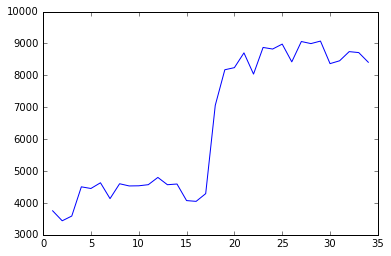

In [1180]:
plt.plot(episodes.season.unique(), mean_scores_by_season);

In [1198]:
aggregations = {
    'stumper': lambda x: sum(x>0)
}

In [1219]:
#Working on seeing how many questions are answered wrong/right per contestant
stumpers = episodes.set_index(['season', 'show_num', 'question_num'])[['c{}_add'.format(i) for i in range(1,5)]].stack().groupby(level=[0,1,2]).agg(aggregations)

In [1221]:
stumpers2 = stumpers.groupby(level=[0,1])['stumper'].agg({'stumpers': lambda x: sum(x==0)/x.count()})

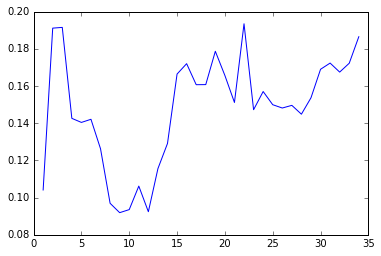

In [1225]:
plt.plot(stumpers2.groupby(level=0)['stumpers'].mean().index,stumpers2.groupby(level=0)['stumpers'].mean().values)

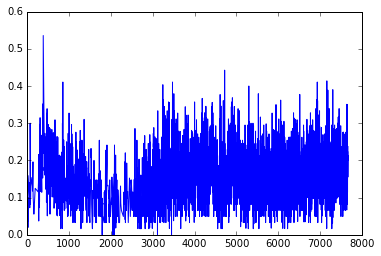

In [1214]:
plt.plot(stumpers2.index, stumpers2.values)

In [1217]:
[x for x,y in zip(stumpers2.index, stumpers2.values) if y > 0.5]

[383]

In [ ]:
episodes['category'].unique()[0:10]